## Import packages

In [9]:
!pip install mediapipe

In [10]:
import cv2
import time
import numpy as np
import mediapipe as mp
import os
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Activation, Dropout

## Get Dataset

In [11]:
filename = "X-Ray-Scanner-Dataset"
datadir = os.path.join(os.getcwd(), filename)  


## Model Training

In [18]:
img_size = 100
 # root data directory
CATEGORIES = os.listdir(datadir)
print(CATEGORIES)

['Dangerous', 'Not Dangerous']


In [39]:
# Define two empty list to contain image data
x, y = [], []

# Modifies all the images to one size for better results
def PreProcess():
    for category in CATEGORIES:
        path = os.path.join(os.getcwd(),"X-Ray-Scanner-Dataset",category)
        classIndex = CATEGORIES.index(category)
        print(path)
        for imgs in tqdm(os.listdir(path)):
            # print(imgs)
            img_arr = cv2.imread(os.path.join(path, imgs))
            
            # resize the image
            resized_array = cv2.resize(img_arr, (img_size, img_size))
            #cv2.imshow("images", resized_array)
            cv2.waitKey(1)
            resized_array = resized_array/255.0
            x.append(resized_array)
            y.append(classIndex)
          
PreProcess()
cv2.destroyAllWindows()

c:\Users\Himadhith\Desktop\mi xray\X-Ray-Detection-to-find-Contraband\Version 3\X-Ray-Scanner-Dataset\Dangerous


100%|██████████| 1450/1450 [00:31<00:00, 46.36it/s]


c:\Users\Himadhith\Desktop\mi xray\X-Ray-Detection-to-find-Contraband\Version 3\X-Ray-Scanner-Dataset\Not Dangerous


100%|██████████| 1279/1279 [00:24<00:00, 51.36it/s]


In [40]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Convert and resize the data to a numpy array
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

In [41]:
# Create the model architecture 

model = Sequential()

model.add(Conv2D(64,(3, 3), input_shape=(img_size, img_size, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(len(CATEGORIES)))
model.add(Activation('softmax'))

# compile the model

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', 
metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 64)        1792      
                                                                 
 activation_5 (Activation)   (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 256)       147712    
                                                                 
 activation_6 (Activation)   (None, 47, 47, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 256)      0         
 2D)                                                  

## Train model

In [44]:
batch_size = 32
epochs = 10
t1 = time.time()
checkpoint_path = os.path.join(datadir,"checkmodels")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# fit the model
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, validation_split=0.3, verbose = 1, callbacks=[cp_callback])
model.save('{}.h5'.format("model"))
t2 = time.time()
print('Time taken: ',t2-t1)

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.7952
Epoch 1: saving model to c:\Users\Himadhith\Desktop\mi xray\X-Ray-Detection-to-find-Contraband\Version 3\X-Ray-Scanner-Dataset\checkmodels
48/48 [==============================] - 4s 62ms/step - loss: 0.4129 - accuracy: 0.7952 - val_loss: 0.2912 - val_accuracy: 0.9282
Epoch 2/10
47/48 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9608
Epoch 2: saving model to c:\Users\Himadhith\Desktop\mi xray\X-Ray-Detection-to-find-Contraband\Version 3\X-Ray-Scanner-Dataset\checkmodels
48/48 [==============================] - 2s 34ms/step - loss: 0.1256 - accuracy: 0.9601 - val_loss: 0.0835 - val_accuracy: 0.9695
Epoch 3/10
47/48 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9814
Epoch 3: saving model to c:\Users\Himadhith\Desktop\mi xray\X-Ray-Detection-to-find-Contraband\Version 3\X-Ray-Scanner-Dataset\checkmodels
48/48 [==============================] - 

In [45]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_test)

18/18 [==============================] - 1s 27ms/step - loss: 0.0264 - accuracy: 0.9927


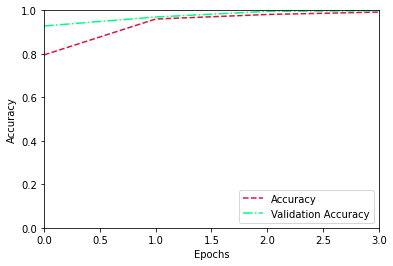

In [46]:
plt.plot(history.history['accuracy'], label = 'Accuracy', linestyle = '--' , color='crimson')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linestyle = 'dashdot', color='springgreen')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlim(0, 3)
plt.legend(loc = "lower right")

In [47]:
#Show the predictions from the model
predictions = model.predict(X_test)
print(predictions)

18/18 [==============================] - 0s 17ms/step
[[1.0000000e+00 3.8206014e-16]
 [4.2775846e-06 9.9999571e-01]
 [9.8113993e-18 1.0000000e+00]
 ...
 [9.8979650e-20 1.0000000e+00]
 [1.0000000e+00 1.4210834e-11]
 [5.3556645e-21 1.0000000e+00]]


In [48]:
from tensorflow.keras.models import load_model


In [33]:
model_save = load_model(os.path.join(os.getcwd(),'model.h5'))

In [5]:
img_size=100

In [59]:
#Predict for the particular image
def predict(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (img_size, img_size))
    img = img/255.0
    img = np.array(img).reshape(-1, img_size, img_size, 3)
    prediction = model.predict(img)
    print(prediction)
    print(CATEGORIES[np.argmax(prediction)])

img = os.path.join(os.getcwd(),"test.jpeg")
predict(img)

1/1 [==============================] - 0s 28ms/step
[[0.17702746 0.8229725 ]]
Not Dangerous
